In [1]:
from deep_traffic_generation.tcvae_pairs import TCVAE_Pairs
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../deep_traffic_generation/data/training_datasets/to_LSZH_16_100.pkl", "../deep_traffic_generation/data/training_datasets/ga_LSZH_14_100.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 7000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    # scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

ATTENTION: 
A chaque fois qu'on génère un dataset, les paires sont prises aléatoirement parmi toutes les paires possibles (nb(ga)*nb(to) = 550000 possiblités). Lors de l'entrainement, on prend aléatoirement un sous ensemble des paires (7000 pour la V6). Lorsqu'on appelle la classe TrafficDatasetPairsRandom pour analyser les résultats, on ne peut pas regénérer exactement le dataset qui a été utiliser pour l'apprentissage. Cela signifie que, lorsqu'on analyse la "reconstruction", on analyse la reconstruction de paires qui n'ont pas forcément été vue durant l'apprentissage. En revanche, cela permet de voir si les encoders takeoffs et goarounds ont été efficaces pour apprendre à reconstruire leurs trajectoires respectives. 

Plusieurs possibilité :
- Soit on laisse comme ça et on spécifie bien qu'on a pas les paires de l'apprentissages, mais les trajectories individuelles ont quand même été vues dans d'autres paires dans l'apprentissages. C'est la'ssociations des trajesctoires qui n'est pas le même
- Soit on apprend sur toutes les possibilités. Ca fait beaucoup et on a beaucoup d'information redondant. On même go around est vu dans nb(to) paires différentes
- Soit On fait le choix des paires avant (une liste d'int), on sauvegarde, et on passe cette liste à la classe TrafficDatasetPairsRandom.

In [3]:
path = "../deep_traffic_generation/lightning_logs/tcvae_pairs/version_6/"

t = PairsVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) 

In [4]:
traffic_to = Traffic.from_file("../deep_traffic_generation/data/training_datasets/to_LSZH_16_100.pkl")
latlon = traffic_to.data.groupby(by="flight_id")[["latitude", "longitude"]].first()
print("Take-offs:", latlon.latitude.mean(), latlon.longitude.mean())

traffic_ga = Traffic.from_file("../deep_traffic_generation/data/training_datasets/ga_LSZH_14_100.pkl")
latlon = traffic_ga.data.groupby(by="flight_id")[["latitude", "longitude"]].first()
print("Go-Arounds:", latlon.latitude.mean(), latlon.longitude.mean())

Take-offs: 47.44463545742907 8.557321498760901
Go-Arounds: 47.500085790354625 8.5114919243637


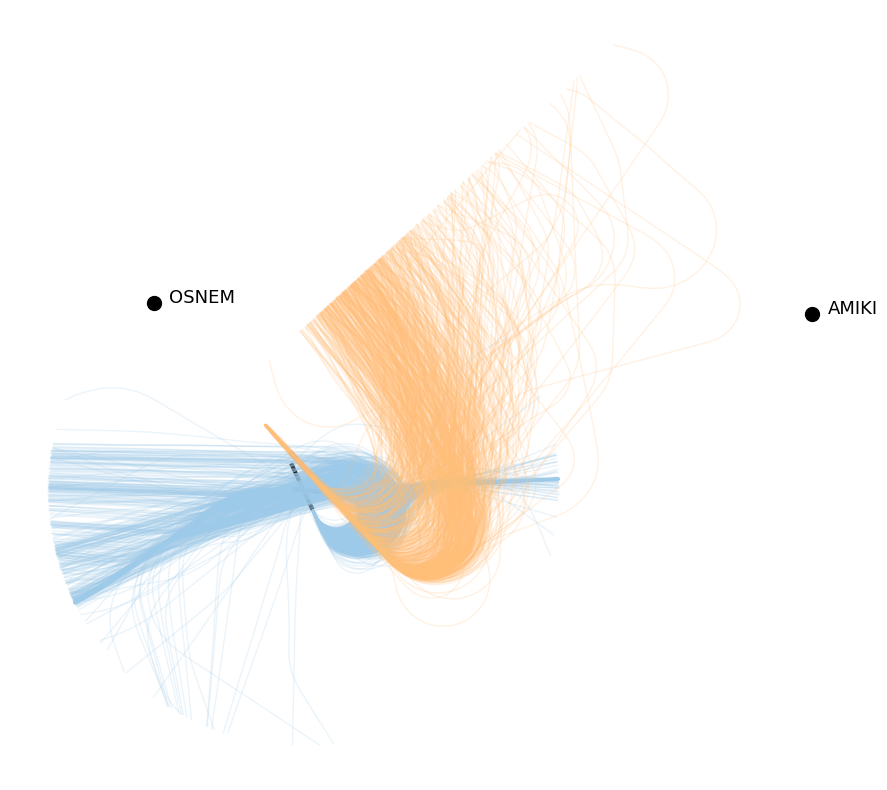

In [5]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.data import navaids, airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    traffic_to[:1000].plot(ax, alpha=0.2, color = "#9ecae9")
    traffic_ga.plot(ax, alpha = 0.2, color = "#ffbf79")

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["OSNEM"].plot(ax)
    navaids["AMIKI"].plot(ax)

plt.show()

# Latent space

In [5]:
h1 = t.VAE.encoder_traj1(dataset.data1)
h2 = t.VAE.encoder_traj2(dataset.data2)
h = torch.cat((h1, h2), dim = 1)
q = t.VAE.lsr(h)

#Scale of the decoders networks
print(t.VAE.scale_traj1, t.VAE.scale_traj2) 

Parameter containing:
tensor([0.0102], requires_grad=True) Parameter containing:
tensor([0.0063], requires_grad=True)


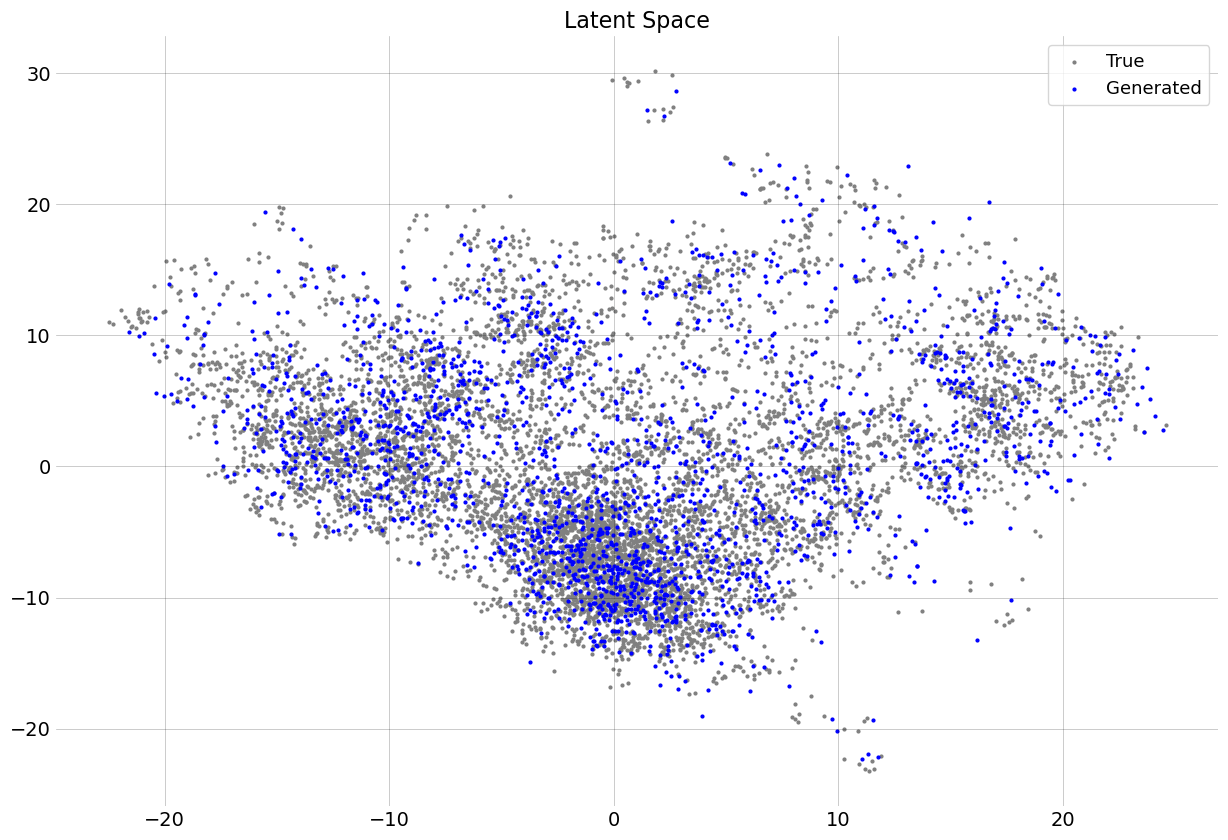

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 2000
Z, Z_gen = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z)
Z_emb = pca.transform(Z)
Z_gen_emb = pca.transform(Z_gen)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.scatter(Z_emb[:, 0], Z_emb[:, 1], s=4, c ='grey', label = "True")
    ax.scatter(Z_gen_emb[:, 0], Z_gen_emb[:, 1], s=4, c='blue', label = "Generated")
    
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

# Reconstruction

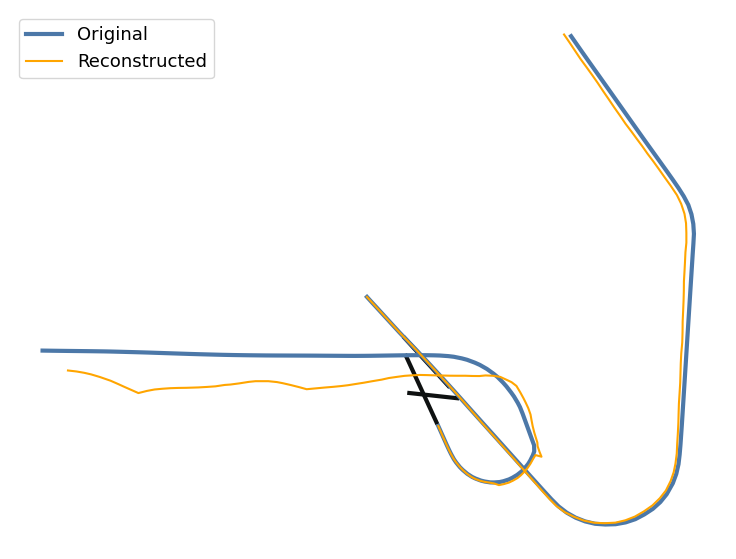

In [8]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

#Original trajectories
original1 = dataset.data1[j].unsqueeze(0)
original1 = original1.transpose(1,2).reshape((original1.shape[0], -1))
original2 = dataset.data2[j].unsqueeze(0)
original2 = original2.transpose(1,2).reshape((original2.shape[0], -1))
original = torch.cat((original1, original2), dim = 1)
original = dataset.scaler.inverse_transform(original)
original_traf_to = g.build_traffic(original[:,:original1.shape[1]], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
original_traf_ga = g.build_traffic(original[:,original2.shape[1]:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)

#Latest variables
h1 = t.VAE.encoder_traj1(dataset.data1[j].unsqueeze(0))
h2 = t.VAE.encoder_traj2(dataset.data2[j].unsqueeze(0))
h = torch.cat((h1, h2), dim = 1)
z = t.VAE.lsr(h).rsample()

#Reconstruction
decoded = t.decode(z)
reconstructed_traf_to = g.build_traffic(decoded[:,:400], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
reconstructed_traf_ga = g.build_traffic(decoded[:,400:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    original_traf_to.plot(ax, c="#4c78a8", lw = 3, label = "Original")
    original_traf_ga.plot(ax, c="#4c78a8", lw = 3)
    reconstructed_traf_to.plot(ax, c="orange", label = "Reconstructed")
    reconstructed_traf_ga.plot(ax, c="orange")
    plt.legend()

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

    plt.show()

# Generation

## Pseudo-inputs

In [9]:
#Computing the pseudo inputs
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X1 = pseudo_X[:,:400].view((pseudo_X.shape[0], 4, 100))
pseudo_X2 = pseudo_X[:,400:].view((pseudo_X.shape[0], 4, 100))

pseudo_h1 = t.VAE.encoder_traj1(pseudo_X1)
pseudo_h2 = t.VAE.encoder_traj2(pseudo_X2)
pseudo_h = torch.cat((pseudo_h1, pseudo_h2), dim = 1)

pseudo_means = t.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries

decoded = t.decode(pseudo_means)
t1, t2 = decoded[:,:400], decoded[:,400:]
t1[:,3] = 0
t2[:,3] = 0
gen_traf_to = g.build_traffic(t1, coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
gen_traf_ga = g.build_traffic(t2, coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)

z_train = t.latent_space(0)
pca = PCA(n_components=2).fit(z_train)
Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)
Z_embedded = pca.transform(Z)

/tmp/ipykernel_21644/4255555629.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(points, ax=ax0)


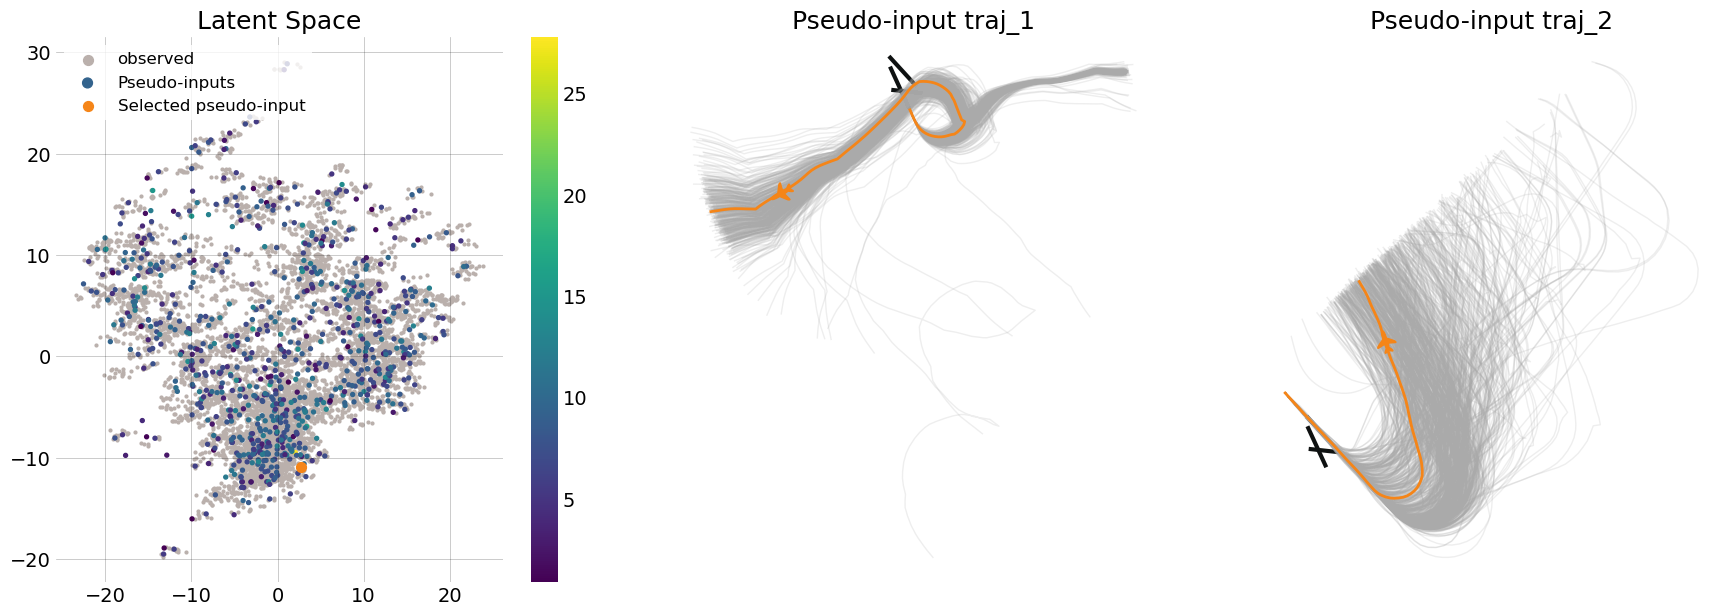

In [23]:
#col depending on the scales
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(18, 12))
    ax0 = fig.add_subplot(231)
    ax1 = fig.add_subplot(232, projection=EuroPP())
    ax2 = fig.add_subplot(233, projection=EuroPP())

    k = np.random.randint(800)


    ax0.scatter(
        Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], c="#bab0ac", s=4, label="observed"
    )
    points = ax0.scatter(
        Z_embedded[-len(pseudo_means):, 0],
        Z_embedded[-len(pseudo_means):, 1],
        s=8,
        c=col,
        cmap="viridis",
        label="Pseudo-inputs",
    )
    ax0.scatter(
        Z_embedded[z_train.shape[0]+k, 0],
        Z_embedded[z_train.shape[0]+k, 1],
        s=50,
        marker="o",
        c="#f58518",
        label="Selected pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    fig.colorbar(points, ax=ax0)

    ax1.set_title("Pseudo-input traj_1", fontsize=18)
    gen_traf_to.plot(ax1, alpha=0.2)
    gen_traf_to["TRAJ_" + str(k)].plot(ax1, color="#f58518", lw=2)
    gen_traf_to["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )
    
    ax2.set_title("Pseudo-input traj_2", fontsize=18)
    gen_traf_ga.plot(ax2, alpha=0.2)
    gen_traf_ga["TRAJ_" + str(k)].plot(ax2, color="#f58518", lw=2)
    gen_traf_ga["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax2,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].plot(ax1, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].plot(ax2, footprint=False, runways=dict(lw=1), labels=False)
    fig.tight_layout()
    plt.show()

# Random Generation

In [29]:
import pandas as pd

j = np.random.randint(0,800)
n_gen = 100

dist = torch.distributions.Independent(
    torch.distributions.Normal(pseudo_means[j], pseudo_scales[j]), 1
)
gen = dist.sample(torch.Size([n_gen]))

decoded = t.decode(
    torch.cat((pseudo_means[j].unsqueeze(0), gen), axis=0)
)
decode1, decode2 = decoded[:,:400], decoded[:,400:]
decode1[:, 3] = 0
decode2[:, 3] = 0

traf_gen1 = g.build_traffic(decode1, coordinates =  dict(latitude =  47.44464, longitude = 8.55732), forward=True)
traf_gen1 = traf_gen1.assign(gen_number=lambda x: 1)

traf_gen2 = g.build_traffic(decode2, coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)
traf_gen2 = traf_gen2.assign(gen_number=lambda x: 2)

z_train = t.latent_space(0)
pca = PCA(n_components=2).fit(z_train)
gen = torch.cat((gen, pseudo_means[j].unsqueeze(0)), axis=0)
concat = np.concatenate((z_train, gen.detach().numpy()))
gen_embedded = pca.transform(concat)

gen_embedded = pd.DataFrame(gen_embedded, columns=["X1", "X2"])
gen_embedded["type"] = np.nan
gen_embedded.type[-(n_gen + 1) :] = "GEN"
gen_embedded.type[-1:] = "PI"

/tmp/ipykernel_21644/2072988786.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_embedded.type[-(n_gen + 1) :] = "GEN"


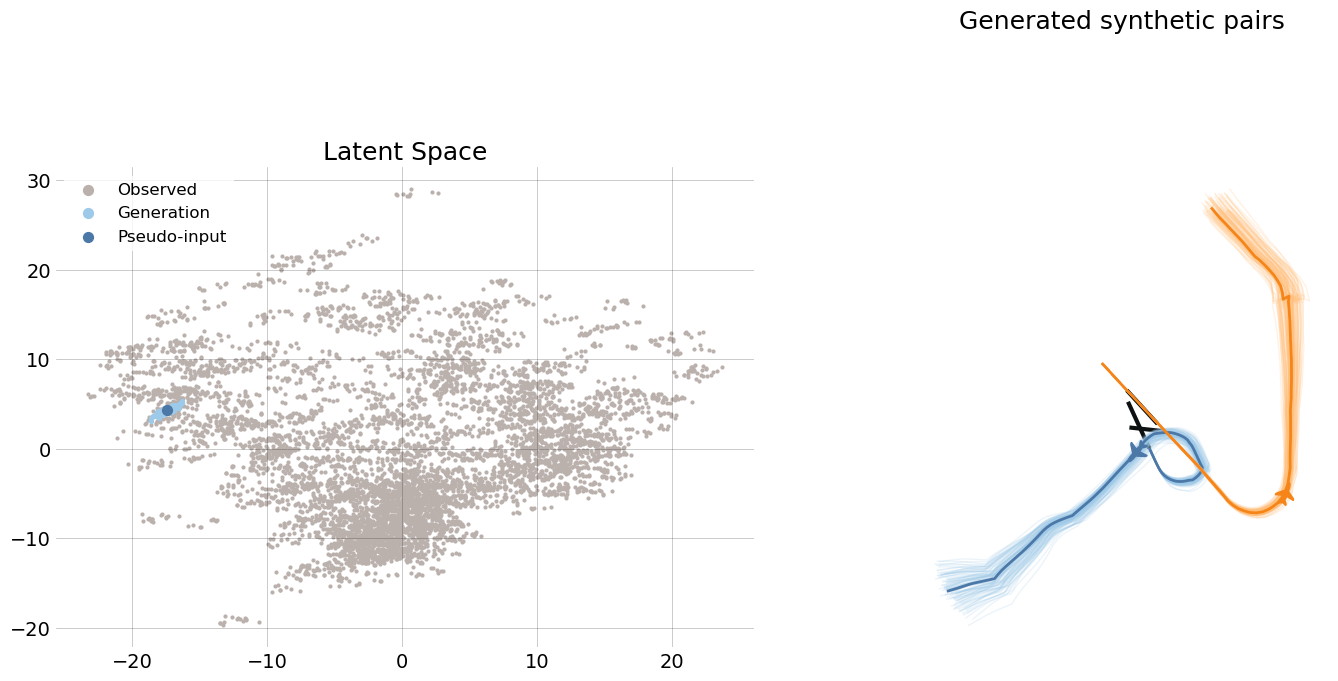

In [30]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    ax0.scatter(
        gen_embedded.query("type.isnull()").X1,
        gen_embedded.query("type.isnull()").X2,
        c="#bab0ac",
        s=4,
        label="Observed",
    )
    ax0.scatter(
        gen_embedded.query("type == 'GEN'").X1,
        gen_embedded.query("type == 'GEN'").X2,
        c="#9ecae9",
        s=8,
        label="Generation",
    )
    ax0.scatter(
        gen_embedded.query("type == 'PI'").X1,
        gen_embedded.query("type == 'PI'").X2,
        c="#4c78a8",
        s=50,
        label="Pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    ax1.set_title("Generated synthetic pairs", pad=100, fontsize=18)

    traf_gen1.plot(ax1, alpha=0.2, color="#9ecae9")
    traf_gen1["TRAJ_0"].plot(ax1, color="#4c78a8", lw=2)
    traf_gen1["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#4c78a8",
        zorder=5,
        text_kw={"s": None},
    )

    traf_gen2.plot(ax1, alpha=0.2, color="#ffbf79")
    traf_gen2["TRAJ_0"].plot(ax1, color="#f58518", lw=2)
    traf_gen2["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].plot(ax1, footprint=False, runways=dict(lw=1), labels=False)
    fig.tight_layout()

    plt.show()